# DETECTING CELLS/CLUSTERS IN A BIOFILM

## Some remarks
- only 1 timepoint, tracking over time will require a separate approach
- parameters still need to be optimized:
    - frangi settings : are there shapes that are not well highlighted ? => tweak alpha, beta, gamma
    - threshold : cfr otsu_factor
    - peaks used for watershedding : peak_local_max allows to filter out false positive peaks via thresholding
- use of other filters : check scikit-image for ideas. Lots of possibilities.  for example morphologic operation (erosion) on the binary image could allow one to separate clusters that are stuck together.  Or filter out small clusters, ..
- this pipeline should be performant enough to run on large files
    - frangi filter can be sped up by decreasing the scale range ('sigmas'), but this might deteriorate the result



In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys

from skimage import data, img_as_float, dtype_limits,img_as_int
from skimage.filters import gaussian, laplace,frangi,laplace,threshold_otsu
from skimage.segmentation import active_contour, watershed
from skimage.io import imread,imshow
from skimage.morphology import binary_closing, closing, square, skeletonize
from tifffile import TiffFile,imwrite
from skimage.morphology import label
from skimage.segmentation.morphsnakes import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set,circle_level_set)
from scipy.ndimage.morphology import distance_transform_edt 
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import time

d_filter_arg = {}

In [2]:
##convenience function

def plot_comparison(original, filtered, filter_name='filtered',original_name = 'original',cmap="nipy_spectral",size=(16,8)):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=size, sharex=True,
                                   sharey=True)
    
    if original_name=='raw':
        ax1.imshow(original)
    else:
        ax1.imshow(original,cmap=cmap)
    
    ax1.set_title(original_name)
    
        
    ax1.axis('off')
    ax2.imshow(filtered, cmap=cmap)
    ax2.set_title(filter_name)
    ax2.axis('off')
    
def slice_comparison(original, filtered,z=37,original_name='original',filter_name = 'filtered'):
    a_slice_filtered = filtered[z:z+1,:,:].squeeze()
    a_slice_img= original[z:z+1,:,:].squeeze()
    plot_comparison(a_slice_img, a_slice_filtered, filter_name= filter_name + "(z={0})".format(z),original_name = original_name)
    return

# A quick look at the raw data

In [3]:
TIFF_FILE ="./Images/WT_ECTracer_100x_zstack_opt_Airyscan Processing_c2_1cluster.tif"
SLICE_Z = [36,37]

img3D = TiffFile(TIFF_FILE).asarray()   
print(TIFF_FILE, '=> shape ->',img3D.shape)

if len(img3D.shape)==4:
    a_slice = img3D[0,SLICE_Z[0]:SLICE_Z[1],:,:]
else:
    a_slice = img3D[SLICE_Z[0]:SLICE_Z[1],:,:]
a_slice = a_slice.reshape(a_slice.shape[1],a_slice.shape[2])
print(a_slice.dtype,a_slice.shape)

img2D = np.invert(a_slice)
print('=> shape 2D ->',img2D.shape)
plt.imshow(img2D)

FileNotFoundError: [Errno 2] No such file or directory: '/home/wth/Downloads/SYNC/Images/WT_ECTracer_100x_zstack_opt_Airyscan Processing_c2_1cluster.tif'

# STEP 1 : 3D Frangi : detect blob like structures in 3D

(note to self => frangi 3D only in scikit image > v15, frangi2D is flawed in this version however)

https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=frangi#skimage.filters.frangi

sigmasiterable of floats, optional
Sigmas used as scales of filter, i.e., np.arange(scale_range[0], scale_range[1], scale_step)

scale_range2-tuple of floats, optional
The range of sigmas used.

scale_stepfloat, optional
Step size between sigmas.

alphafloat, optional
Frangi correction constant that adjusts the filter’s sensitivity to deviation from a plate-like structure.

betafloat, optional
Frangi correction constant that adjusts the filter’s sensitivity to deviation from a blob-like structure.

gammafloat, optional
Frangi correction constant that adjusts the filter’s sensitivity to areas of high variance/texture/structure.

black_ridgesboolean, optional
When True (the default), the filter detects black ridges; when False, it detects white ridges.

mode{‘constant’, ‘reflect’, ‘wrap’, ‘nearest’, ‘mirror’}, optional
How to handle values outside the image borders.

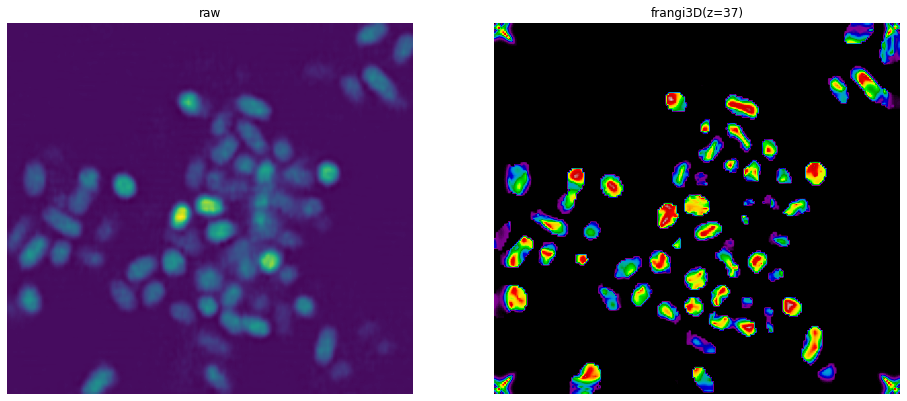

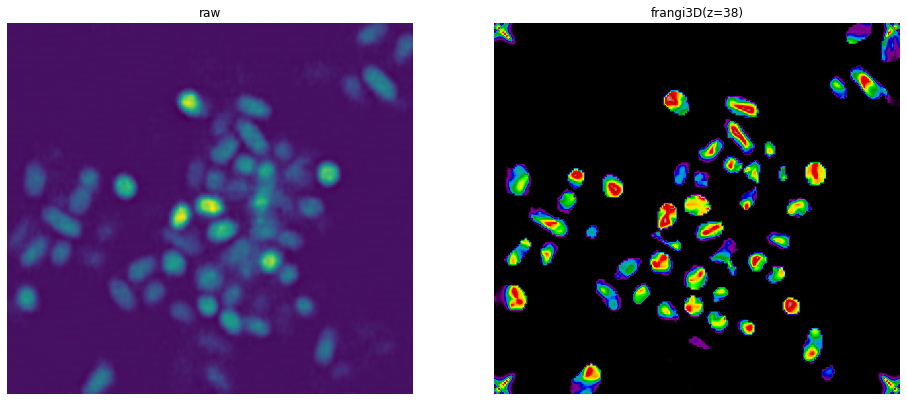

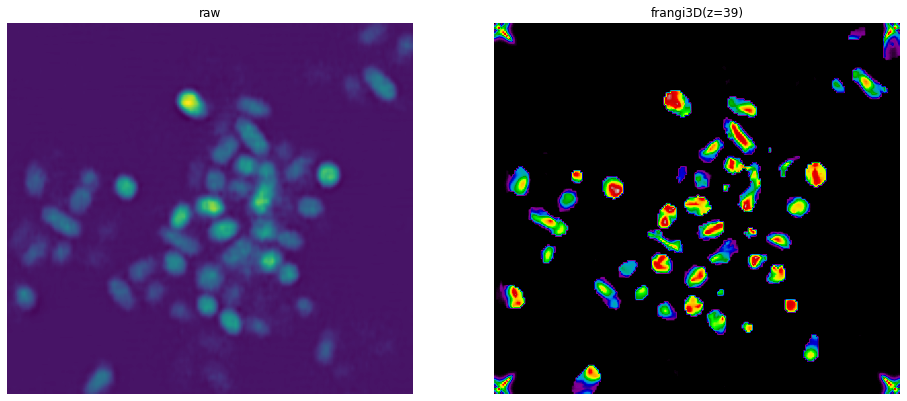

In [9]:
d_filter_arg['frangi3D'] = {'sigmas': [1,3],
                        'scale_step': 1,
                        'alpha': 0.5,
                        'beta': 2,
                        'gamma': 0.005,
                        'black_ridges': True}

frangi_img3D = frangi(np.invert(img3D), **d_filter_arg['frangi3D']) 
slice_comparison(img3D,frangi_img3D,original_name = 'raw',filter_name="frangi3D",z=37)
slice_comparison(img3D,frangi_img3D,original_name = 'raw',filter_name="frangi3D",z=38)
slice_comparison(img3D,frangi_img3D,original_name = 'raw',filter_name="frangi3D",z=39)


# STEP 2 : Binarize Frangi output

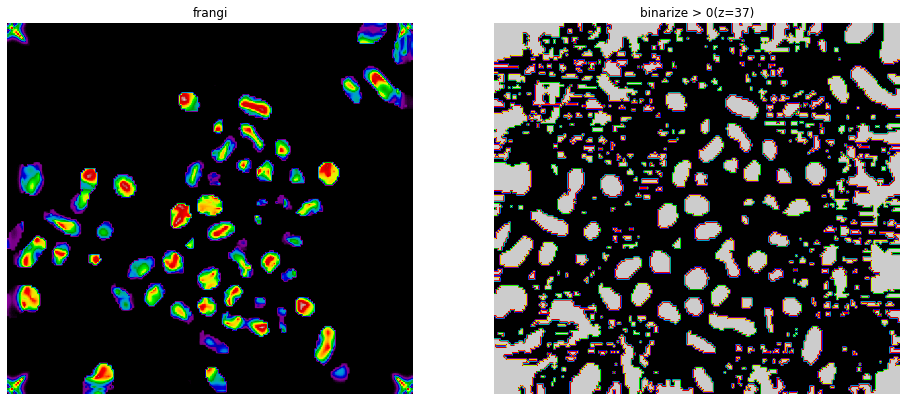

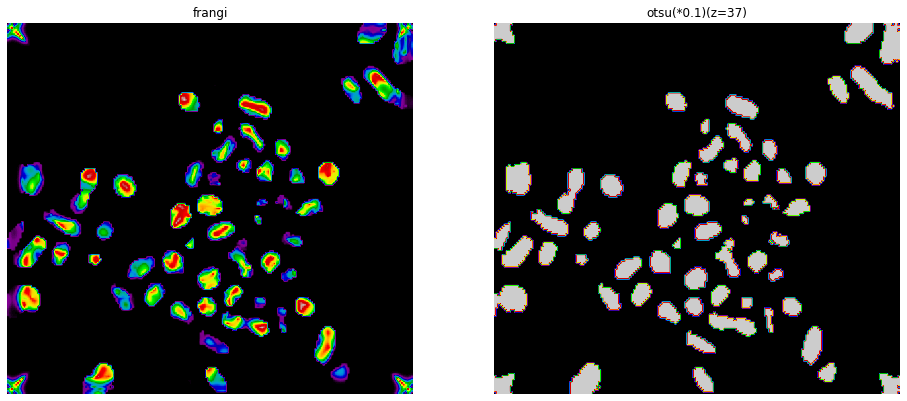

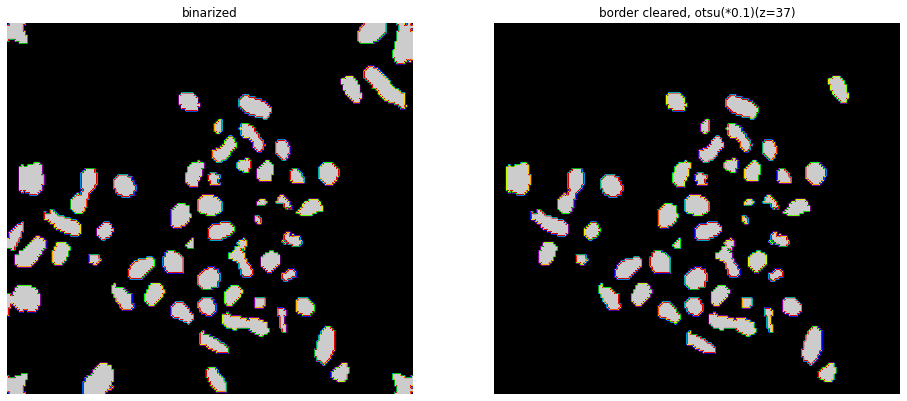

In [11]:
# simple absolute threshold (just to check non-zero values)
bin_img = np.where(frangi_img3D>0,1,0)
slice_comparison(frangi_img3D,bin_img,original_name = 'frangi',filter_name="binarize > 0",z=37)

# apply otsu threshold
otsu_factor = 0.1 # manual tweaking: take Otsu as reference point, but we can drop quite a bit lower because Frangi is very good at reducing background noise
bin_img = np.where(frangi_img3D>threshold_otsu(frangi_img3D)*otsu_factor,1,0)
slice_comparison(frangi_img3D,bin_img,original_name = 'frangi',filter_name="otsu(*{0})".format(otsu_factor),z=37)

# clear outside cells (optional)
from skimage.segmentation import clear_border
bin_img_cleared =clear_border(bin_img)
slice_comparison(bin_img,bin_img_cleared,original_name = 'binarized',filter_name="border cleared, otsu(*{0})".format(otsu_factor),z=37)

# STEP 3 : SEGMENTATION 
Various approaches are possible.  Here I thresholded the DT image.  you could also do peak finding on the DT image and I can think of 2 ways to locate those peaks (peak_local_max, and H-max).   But given this data I think thresholding will give the best results

## 3.1 Compose Distance transform
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html

Histogram of DT :
 values
 [4872401   39300   13936   28865   11338    7878    6008    1315     432
       9] 
 with bin_edges 
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2 4.8 5.4 6. ]


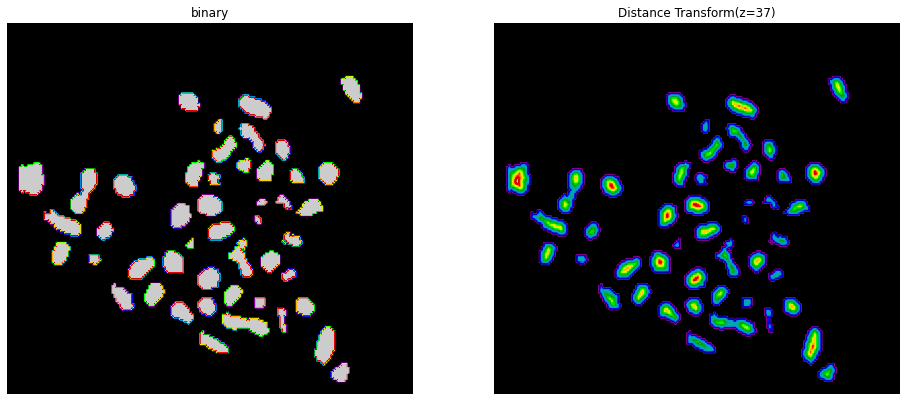

In [13]:
pixel_width = 0.0817493
voxel_depth = 0.1569734 #check fiji

DT_img = distance_transform_edt(bin_img_cleared, sampling = [(voxel_depth / pixel_width) ,1,1], 
                                       return_distances=True, return_indices=False) 
imwrite("./OUTPUT/DT_img.tif", (DT_img))


slice_comparison(bin_img_cleared,DT_img,original_name = 'binary',filter_name="Distance Transform",z=37)

print("Histogram of DT :{2} values{2} {0} {2} with bin_edges {2}{1}".format(np.histogram(DT_img)[0],np.histogram(DT_img)[1],"\n"))

## 3.2  Binarize Distance transform
This is the crucial step !  the rest of the steps are quite generic.  The end result should be a binary image where every cluster of pixels represents a different cell.  so, the binary image you get will determine how many cells you detect/miss.  
threshold_abs needs to be set at an optimum value to achieve this  
Luckily the salmonella bacteria all have more or less the same shape and size.  This will make this thresholding a reasonable approach.   
 If all bacteria were nicely separated and perfectly detected by Frangi, it would be trivial to identify them.  BUT..  
We have 2 opposing challenges :   
1. cells can overlap.  In this case we want to separate them into 2 cells.  The higher we set the threshold the more of those overlaps we can separate them into 2 separate clusters.  increasing the threshold will also erase small cells (artefacts) that Frangi has detected
2. 1 cell can have an irregular shape (due to biology, microscopy, or because Frangi was not working perfectly). this means 1 cell can have multiple maxima inside its interior.  in this case we want to keep these together as 1 cell.  DEcreasing the threshold will allow us the cluster them together.  
These opposing challenges require us to find a sweet spot for threshold_abs.  The good news again is that this can be calibrated once and can be reused on later datasets (because the bacteria shape remains the same, and assuming the resolution of the micrscopy is not altered).   

How to find the sweetspot ? :   
- If you look at the DT-image, you will see that a bacteria has a max DT inside the interior of around 4 (more or less).   
- If you look at cells that overlap, the overlap zone usually has a maximum DT value of 2 (again, a rough estimate)  
- if you look at 1 cell with multiple local maxima inside its interior, those maxima are usually above 3 (harder to see, because you have to check in 3D if it is really a maximum)  
- So, threshold_abs=2.5 seems to be a reasonable guess to start from.  You will never get a perfect segmentation however

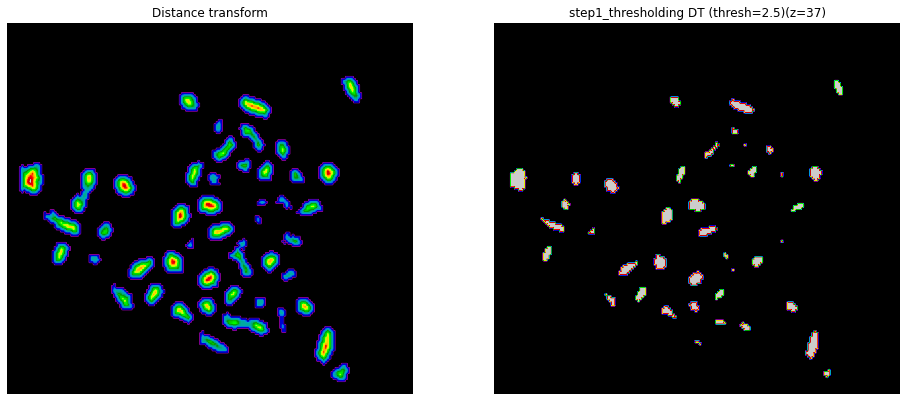

In [14]:
threshold_abs=2.5 ## Find sweetspot between [0,5]
local_maxi = np.where(DT_img>threshold_abs,1,0) 
#local_maxi = peak_local_max(DT_img_int, indices=False, threshold_abs=threshold_abs,labels=DT_img_int) #completely equivalent to above 


#viz
slice_comparison(DT_img,local_maxi,original_name = 'Distance transform',filter_name="step1_thresholding DT (thresh={0})".format(threshold_abs),z=37)



## 3.3 Label binary image

133 cells (labels) are detected


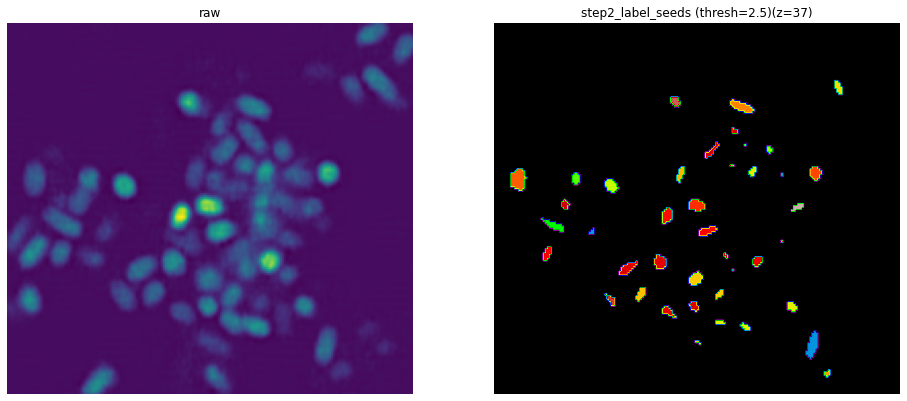

In [18]:
label_img = ndi.label(local_maxi)[0] #uses a structuring element of 1 connectivity, so only diagonal touching is ignored, the 3D equivalent of a 2D cross. you can use structuring element to move through the pixels, if you can't reach another group of pixels, these two groups get a different label

a_unique_labels = np.unique(label_img)
print('{0} cells (labels) are detected'.format(a_unique_labels.shape[0] - 1 ))  # 0 = background

slice_comparison(img3D,label_img,original_name = 'raw',filter_name="step2_label_seeds (thresh={0})".format(threshold_abs),z=37)


## 3.4 : restore shape = seeded watershed on the 3D DT

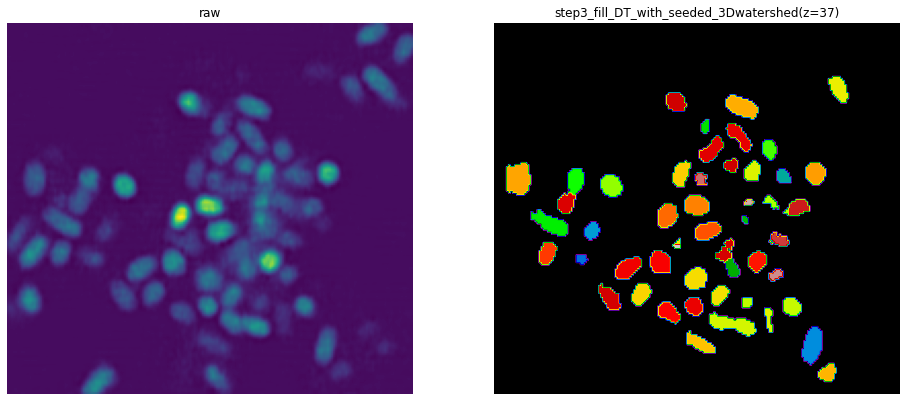

In [16]:
ws_img = watershed(-DT_img, label_img_2, mask=DT_img)  

slice_comparison(img3D,ws_img,original_name = 'raw',filter_name="step3_fill_DT_with_seeded_3Dwatershed",z=37)

## 3.5 get center of cells
center = pixel the fartest away from the membrane

In [19]:
for marker_i in a_unique_labels[1:]:
    a_masked_DT = np.where(label_img_2==marker_i,DT_img,0)
    a_masked_DT_max_loc = np.unravel_index(np.argmax(a_masked_DT),a_masked_DT.shape)
    print("label={0} on location ({1},{2},{3})".format(marker_i,a_masked_DT_max_loc[0],a_masked_DT_max_loc[1],a_masked_DT_max_loc[2]))
    

label=1 on location (21,17,35)
label=2 on location (21,15,109)
label=3 on location (30,17,95)
label=4 on location (20,22,146)
label=5 on location (20,29,103)
label=6 on location (21,34,88)
label=7 on location (21,37,124)
label=8 on location (22,37,174)
label=9 on location (20,58,133)
label=10 on location (21,58,96)
label=11 on location (21,64,188)
label=12 on location (21,68,40)
label=13 on location (21,73,162)
label=14 on location (19,78,54)
label=15 on location (21,81,73)
label=16 on location (21,80,94)
label=17 on location (21,89,125)
label=18 on location (20,98,26)
label=19 on location (20,102,69)
label=20 on location (21,136,164)
label=21 on location (22,49,154)
label=22 on location (23,61,25)
label=23 on location (21,79,133)
label=24 on location (21,86,33)
label=25 on location (20,89,17)
label=26 on location (22,89,112)
label=27 on location (21,99,91)
label=28 on location (31,113,36)
label=29 on location (21,114,62)
label=30 on location (24,124,22)
label=31 on location (22,142,10

# Save data

In [22]:
imwrite('./OUTPUT/local_maxi.tif', local_maxi)
imwrite('./OUTPUT/label_img.tif', label_img)
imwrite('./OUTPUT/ws_img.tif', ws_img)

from tifffile import TiffFile,imsave
from skimage import img_as_uint
imsave("./OUTPUT/bin_img_cleared.tif", img_as_uint(bin_img_cleared))